# Project CodeNet Program Classification with a TBCNN

This notebook shows an application of a TBCNN for classifying programs by functionality. In this experiment we use Python source code from Project CodeNet and predict their problem_id.

Structure of this notebook:
1. Creation of a derived dataset from Project CodeNet
2. Training of a TBCNN on this subset
3. Visualizations of the Convolutional Layer of the Model using GraphViz

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Derived Dataset
The derived dataset contains only source code from submissions with status 'Accepted' and programs written in Python 3.4.3. This constraint allows us to parse the code with the built-in Python-module 'ast'.

First, we create an in-memory representation of the CodeNet dataset to retrieve the metadata of all submissions.

In [6]:
from dataset.CodeNet import CodeNet
code_net = CodeNet(location=r"C:\Users\sebas\Documents\Masterarbeit\Project_CodeNet")

In [7]:
submission_metadata = code_net.get_submission_metadata()
submission_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13916868 entries, 0 to 1088
Data columns (total 12 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   submission_id      string
 1   problem_id         string
 2   user_id            string
 3   date               Int64 
 4   language           string
 5   original_language  string
 6   filename_ext       string
 7   status             string
 8   cpu_time           Int64 
 9   memory             Int64 
 10  code_size          Int64 
 11  accuracy           string
dtypes: Int64(4), string(8)
memory usage: 1.4 GB


pandas Dataframes allow us to query and recombine dataframes to construct the derived dataset.

In [8]:
accepted_python3_submissions = submission_metadata.query("original_language == 'Python (3.4.3)' and status == 'Accepted'")

We further use only submissions with more than 2500 submissions, so we have enough data to train on.

In [9]:
python3_submissions_count = accepted_python3_submissions.groupby(["problem_id", "status"]).size().reset_index(name="count").sort_values("count", ascending=False).query("count > 2500")

By merging these two dataframes we get the final derived data we want.

In [10]:
derived_dataset = accepted_python3_submissions.merge(python3_submissions_count, on="problem_id").drop(columns=["status_y"]).rename(columns={"status_x": "status"})

Finally, we use an instance of `ProblemIdClassificationDataset` to manage the dataset on disk. This class offers functionality to create training-, validation- and test-directory with the specified number of samples for each problem. All samples are randomly sampled from the `derived_dataset`

In [11]:
from dataset.ProblemIdClassificationDataset import ProblemIdClassificationDataset

classification_dataset = ProblemIdClassificationDataset(r"C:\Users\sebas\Documents\Masterarbeit\datasets\tbcnn_py3_2500",
                                                 derived_dataset,
                                                 code_net,
                                                 n_train_per_problem=600,
                                                 n_val_per_problem=100,
                                                 n_test_per_problem=300)

The `create_or_load`-method creates an in-memory representation of the classification-dataset or loads it if it already exists in the file system. More specifically, following steps happen during creation:
1. For each `problem_id` in the `derived_dataset` 1000 submissions are sampled (see parameter of Ctor in previous cell).
2. The 1000 samples are split up into train-, validation- and test-partitions according to the parameter in the previous cell. These partitions are represented by dataframes which are serialized with `pickle` for later loading.
3. Each source file is parsed with the `ast` module and a simpler tree in JSON format is created and placed in its respective directory (train, val or test)
4. All encountered AST node types are collected in a map (str->int) and serialized (node_map).
5. All encountered problem_ids (classification labels) are collected and serialized

In [12]:
classification_dataset.create_or_load()

## TBCNN

In [14]:
import tensorflow as tf
from classifier.Tbcnn import Tbcnn
node_map = classification_dataset.get_node_map()
labels = classification_dataset.get_labels()
model = Tbcnn(embedding_size=len(node_map), conv_output_size=100, num_classes=len(labels))
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam',
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [16]:
from classifier.generators.FileStreamDataGenerator import FileStreamDataGenerator
train_files = classification_dataset.get_train_files()
val_files = classification_dataset.get_val_files()
embeddings = []
training_generator = FileStreamDataGenerator(train_files, labels, embeddings, node_map, batch_size=1, shuffle=True)
validation_generator = FileStreamDataGenerator(val_files, labels, embeddings, node_map, batch_size=1, shuffle=False)
model.fit(training_generator, validation_data=validation_generator, epochs=1)

75600/75600 [==============================] - 156s 2ms/step - loss: 0.6173 - categorical_accuracy: 0.8538 - val_loss: 0.2771 - val_categorical_accuracy: 0.9234


In [17]:
test_files = classification_dataset.get_test_files()
test_generator = FileStreamDataGenerator(test_files, labels, embeddings, node_map, batch_size=1, shuffle=False)
model.evaluate(test_generator)

37800/37800 [==============================] - 62s 2ms/step - loss: 0.2792 - categorical_accuracy: 0.9230


[0.2791554927825928, 0.9229629635810852]

## Visualization

In [30]:
conv_filter_activations = model.conv_layer(test_generator.__getitem__(1300)[0])

In [31]:
node_importance = model.pooling_layer(conv_filter_activations)[0]

In [32]:
from collections import Counter

node_importance_list = node_importance.numpy().tolist()[0]
counter = Counter(node_importance_list)

In [33]:
import pickle
with open(test_files[1300], 'rb') as f:
    test_sample_ast = pickle.load(f)

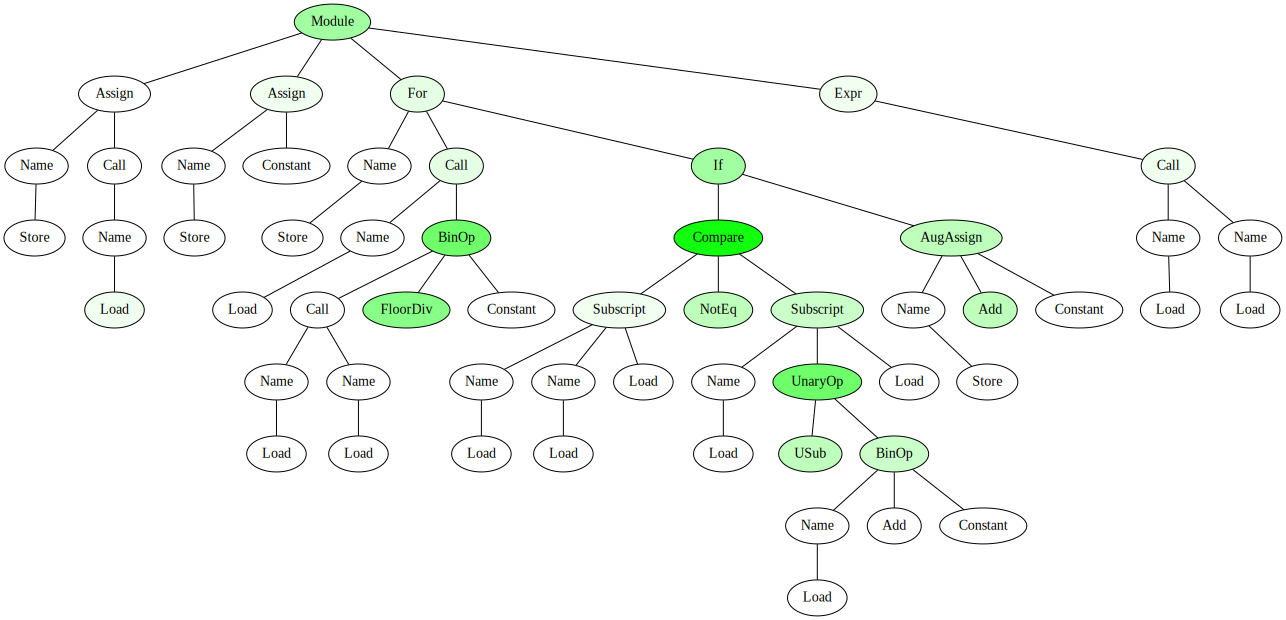

In [34]:
from visualization.GraphvizVisualizer import GraphvizVisualizer

vis = GraphvizVisualizer()
vis.visualizeAst(test_sample_ast, counter)